# Regresion lineal

Vamos a implementar el modelo de regresion lineal que hemos visto en clase. Ahora utilizando las funciones de keras.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
%matplotlib inline

Definamos las semillas de los generadores de numeros aleatorios para que nuestros resultados sean reproducibles. 

In [2]:
tf.random.set_seed(108727)
random.seed(108727)

## Generando datos

Generamos un conjunto de datos sintético. Para esto simularemos
1000 datos observamos, cada uno con 2 atributos generados de una 
normal estandar. Por lo tanto nuestro conjunto de datos será 
$\mathbf{X}\in \mathbb{R}^{1000 \times 2}.$

Los valores que usaremos para los pesos serán 
$\mathbf{w}^\star = [2, -3.4]^\top$ y $b^\star = 4.2$,
y la variable de respuesta observada será registrada de
acuerdo al modelo 

$$\mathbf{y}= \mathbf{X} \mathbf{w}^\star + b^\star + \mathbf{\epsilon}.$$

In [3]:
def synthetic_data(w, b, num_examples): 
    """Generate y = Xw + b + noise."""
    X = tf.zeros((num_examples, w.shape[0]))
    X += tf.random.normal(shape=X.shape)
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1, 1))
    return X, y

true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features:', features[0].numpy(),'\noutput  :', labels[0].numpy())

features: [-1.4190247  -0.40520382] 
output  : [2.7367127]


Podemos usar gráficos de dispersión para validar que nuestros datos satisfacen el supuesto de correlación lineal. 

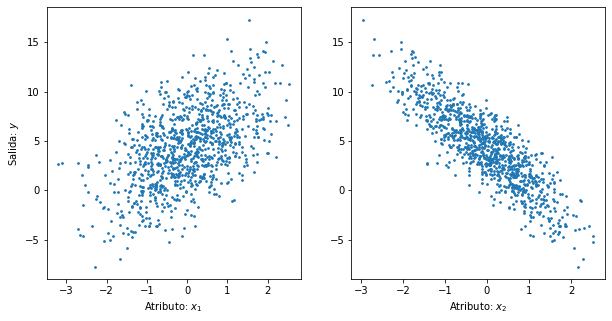

In [5]:
fig, axes = plt.subplots(1, 2, figsize = [10, 5])
axes[0].scatter(features[:, 0].numpy(), labels.numpy(), 3);
axes[0].set_xlabel(r"Atributo: $x_1$"); axes[0].set_ylabel(r"Salida: $y$");

axes[1].scatter(features[:, 1].numpy(), labels.numpy(), 3);
axes[1].set_xlabel(r"Atributo: $x_2$"); axes[0].set_ylabel(r"Salida: $y$");


## Preparando el conjunto de datos

Resolveremos el problema de regresión utilizando el método iterativo que vimos. 
Para esto necesitamos una función que sea capaz de generar los bloques, recibiendo como 
entrada el tamaño de los bloques. Ahora utilizaremos un iterador que ya viene 
en las librerias de `tensorflow`.

In [6]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """Construct a TensorFlow data iterator."""
    dataset = tf.data.Dataset.from_tensor_slices(data_arrays)
    if is_train:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    return dataset

In [7]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [8]:
next(iter(data_iter))

(<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
 array([[-1.855617  ,  1.4968314 ],
        [-0.52445483, -2.0086243 ],
        [-0.61631066,  0.3504027 ],
        [ 0.22675593,  0.23592383],
        [-1.772659  , -0.9567067 ],
        [ 0.9214221 , -0.4683857 ],
        [ 1.3023026 ,  0.5549465 ],
        [-0.08104537, -1.1965384 ],
        [-1.1124128 , -1.3868176 ],
        [-1.5423255 , -0.50628483]], dtype=float32)>,
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[-4.589067 ],
        [ 9.979043 ],
        [ 1.7579306],
        [ 3.8393154],
        [ 3.9052534],
        [ 7.6409745],
        [ 4.9171743],
        [ 8.116236 ],
        [ 6.6730847],
        [ 2.8453887]], dtype=float32)>)

### Inicializamos los valores de los parámetros

El módulo `initializers` tiene ya codificados varios modos de inicializar parámetros. Por el momento sólo tenemos que 
definir el modo en que seran asignados los valores iniciales. Keras se encarga de establecer las dimensiones adecuadas una vez que se ejecuten los comandos necesarios. 

In [9]:
initializer = tf.initializers.RandomNormal(stddev=0.01)

### Definimos el modelo

Como vimos en el diagrama, un modelo de regresion lineal lo podemos interpretar como una red 
neuronal de una capa con una unidad de procesamiento y conexiones densas. Ademas, Keras se encarga de definir las dimensiones adecuadas.

In [10]:
# `keras` is the high-level API for TensorFlow
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

### Definimos la función de pérdida

In [11]:
loss = tf.keras.losses.MeanSquaredError()

### Definimos el algoritmo de optimización

In [12]:
trainer = tf.keras.optimizers.SGD(learning_rate=0.03)

### Entrenamos

In [13]:
num_epochs = 5

for epoch in range(num_epochs):
    for X, y in data_iter:
        with tf.GradientTape() as tape:
            l = loss(net(X, training=True), y)
        grads = tape.gradient(l, net.trainable_variables)
        trainer.apply_gradients(zip(grads, net.trainable_variables))
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000198
epoch 2, loss 0.000095
epoch 3, loss 0.000095
epoch 4, loss 0.000095
epoch 5, loss 0.000094


Nuestros error en los estimadores son:

In [14]:
w = net.get_weights()[0]
b = net.get_weights()[1]

print(f'Error relativo en w: {(true_w - tf.reshape(w, true_w.shape))/true_w}')
print(f'Error relativo en b: {(true_b - b)/true_b}')

Error relativo en w: [2.4229288e-04 4.0110419e-05]
Error relativo en b: [3.6443984e-05]


## Resumen

* Usar las herramientas de TensorFlow nos permite implementar modelos de forma concisa. 
* El modulo `data` de Tenorflow brinda herramientas de procesamiento de datos, `keras` define una gran variedad de modelos y herramientas para aplicaciones.
* El modulo `initializers` permite inicializar parametros para un modelo que usa Tensorflow.
* La dimensionalidad y almacenamiento de los parametros se hacen detras de camara con Keras. Sin embargo, ten cuidado de no tratar de accesar a dichos parametros antes de que hayan sido inicializados por Keras. 

## Ejercicios 

1. Revisa la documentación de Tensorflow para ver que funciones de pérdida y métodos de inicializacion existen. Repite el ajuste del modelo utilizando la pérdida de Huber. 
